<a href="https://colab.research.google.com/github/qowngus33/captcha_recognition/blob/main/Captcha_model_character_12_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# gpu 사용
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import os
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
import numpy as np

np.random.seed(42)

# 데이터를 불러오고 이미지 개수를 출력
data_list = glob('sample_data/samples/*.png')
len_data = len(data_list)
print(len(data_list))

1040


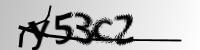

In [ ]:
# 샘플 이미지 출력
img = cv2.imread(data_list[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

In [ ]:
def preprocess_image(image,data_height = 50,data_width = 200,n_channel = 1):
  image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0) # 뒷배경을 제거
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.ones((4,1), np.uint8))
  image = np.reshape(image, (data_height, data_width, n_channel)) / 255   # 모델 학습을 위해 0 - 1 사이의 값으로 스케일링
  return image

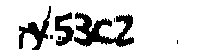

In [ ]:
img = preprocess_image(img)
cv2_imshow(img * 255)

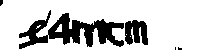

['c' '4' 'm' 'c' 'm']
(1040, 50, 200, 1)


In [ ]:
# 이미지 크기, 채널
data_height = 50
data_width = 200
n_channel = 1

images = np.zeros((len_data, data_height, data_width, n_channel))
label = np.empty((len_data, 5), dtype = str)
characters = []

# 이미지 전처리와 글자 파싱
for n, path in enumerate(data_list):
  image = cv2.imread(data_list[n], cv2.IMREAD_GRAYSCALE)
  image = preprocess_image(image)
  images[n, :, :, :] = image
  path = path.split('/')[2]
  path = path.split('.')[0]
  path = list(path)
  label[n] = np.array(path)
  for i in range(5):
    characters.append(path[i])

cv2_imshow(images[3] * 255)
print(label[3])
print(images.shape)

In [ ]:
from string import ascii_lowercase, digits

# 글자 종류 확인
characters = list(set(characters))
characters.sort()
print(characters)

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


(1040, 5)
[265, 267, 284, 281, 259, 258, 264, 240, 262, 259, 235, 271, 271, 275, 525, 253, 235, 264, 232]


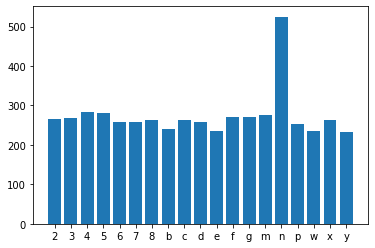

In [ ]:
import matplotlib.pyplot as plt

# 라벨링
def char_to_num(num):
  if num in characters:
    return characters.index(num)
  return None

character_num = [0] * len(characters)

print(label.shape)
for i in range(len(label)):
  for j in range(len(label[0])):
    character_num[char_to_num(label[i,j])] += 1
print(character_num)

x = np.arange(len(characters))
plt.bar(x, character_num)
plt.xticks(x, characters)

plt.show()

In [ ]:
# 원핫인코딩    
num_label = np.empty((5, len_data, len(characters)), dtype = int)
for i in range(len_data):
  targs = np.zeros((5, len(characters)))
  for j, l in enumerate(label[i]):
    ind = char_to_num(l)
    targs[j, ind] = 1
    num_label[:, i] = targs

print(num_label[3][3])

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [ ]:
import random

index_list = np.arange(len_data)
random.shuffle(index_list)
print(index_list)

# train, test split by random index
for i in range(len_data):
  train_X, test_X = images[index_list[:900]], images[index_list[900:]]
  train_y, test_y = num_label[:,index_list[:900]], num_label[:,index_list[900:]]

print(len(train_X),len(test_X))
print(train_X.shape)
print(len(train_y[0]),len(test_y[0]))
print(train_y[3])

[761 432 893 ... 373 331 879]
900 140
(900, 50, 200, 1)
900 140
[[0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras import layers

In [ ]:
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1,activation="relu",**kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
        keras.layers.Conv2D(filters,3,strides=strides,
                            padding="same",use_bias=False),
        keras.layers.BatchNormalization(),
        self.activation,
        keras.layers.Conv2D(filters,3,strides=1,
                            padding="same",use_bias=False),
        keras.layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
        keras.layers.Conv2D(filters,1,strides=strides,
                            padding="same",use_bias=False),
        keras.layers.BatchNormalization()
      ]
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)


In [ ]:
def build_model(num_classes):
    img = layers.Input(shape=(50, 200, 1))
    conv1 = layers.Conv2D(64, (7, 7), padding='same',activation="relu")(img)
    mp1 = layers.MaxPool2D(2)(conv1)
    conv2 = layers.Conv2D(128, (3, 3), padding='same',activation="relu")(mp1)
    conv3 = layers.Conv2D(128, (3, 3), padding='same',activation="relu")(conv2)
    mp2 = layers.MaxPool2D(2)(conv3)
    conv4 = layers.Conv2D(128, (3, 3), padding='same',activation="relu")(mp2)
    bn = layers.BatchNormalization()(conv4)
    conv5 = layers.Conv2D(128, (3, 3), padding='same',activation="relu")(bn)
    mp3 = layers.MaxPool2D(2)(conv5)
    flat = layers.Flatten()(mp3)
      
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(128,activation='relu')(flat)
        drop1 = layers.Dropout(0.5)(dens1)
        dens2 = layers.Dense(64,activation='relu')(drop1)
        drop2 = layers.Dropout(0.5)(dens2)
        res = layers.Dense(num_classes, activation='softmax')(drop2)
        outs.append(res)
    
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])
    return model

In [ ]:
num_classes = len(characters)
model = build_model(num_classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_44 (Conv2D)             (None, 50, 200, 64)  3200        ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 25, 100, 64)  0          ['conv2d_44[0][0]']              
                                                                                                  
 conv2d_45 (Conv2D)             (None, 25, 100, 128  73856       ['max_pooling2d_7[0][0]']  

In [ ]:
# batch size epoch grid search
batch_size = [2, 4, 8, 16, 32, 64, 128]
epochs = [10, 50, 100]

accuracys = []
cycle = len(batch_size) * len(epochs)
idx = 0 

for batchSize in batch_size:
  for epoch in epochs:
    print(f'{idx}/{cycle}')
    hist = model.fit(train_X, [train_y[0], train_y[1], train_y[2], train_y[3], train_y[4]], 
                     batch_size=batchSize, epochs=epoch, validation_split=0.2).history
    result = sum([hist["val_dense_22_accuracy"][epoch-1],hist["val_dense_25_accuracy"][epoch-1],
                  hist["val_dense_28_accuracy"][epoch-1],hist["val_dense_31_accuracy"][epoch-1],
                  hist["val_dense_34_accuracy"][epoch-1]])/5
    a = {"epoch": epoch, "batch_size": batchSize, "val accuracy":result}
    accuracys.append(a)
    idx += 1

0/21
Epoch 1/10
360/360 [==============================] - 5s 14ms/step - loss: 3.8467 - dense_22_loss: 0.4760 - dense_25_loss: 0.8365 - dense_28_loss: 0.6556 - dense_31_loss: 0.9405 - dense_34_loss: 0.9381 - dense_22_accuracy: 0.8583 - dense_25_accuracy: 0.7472 - dense_28_accuracy: 0.8319 - dense_31_accuracy: 0.7458 - dense_34_accuracy: 0.7208 - val_loss: 3.3020 - val_dense_22_loss: 0.2402 - val_dense_25_loss: 0.5068 - val_dense_28_loss: 0.5906 - val_dense_31_loss: 1.1224 - val_dense_34_loss: 0.8419 - val_dense_22_accuracy: 0.9389 - val_dense_25_accuracy: 0.8167 - val_dense_28_accuracy: 0.8667 - val_dense_31_accuracy: 0.7667 - val_dense_34_accuracy: 0.7056
Epoch 2/10
360/360 [==============================] - 5s 13ms/step - loss: 3.0988 - dense_22_loss: 0.3816 - dense_25_loss: 0.7017 - dense_28_loss: 0.5184 - dense_31_loss: 0.6957 - dense_34_loss: 0.8014 - dense_22_accuracy: 0.8931 - dense_25_accuracy: 0.7722 - dense_28_accuracy: 0.8361 - dense_31_accuracy: 0.7917 - dense_34_accuracy:

In [ ]:
for accuracy in accuracys:
  print(accuracy)

{'epoch': 10, 'batch_size': 2, 'val accuracy': 0.8822222352027893}
{'epoch': 50, 'batch_size': 2, 'val accuracy': 0.8866666674613952}
{'epoch': 100, 'batch_size': 2, 'val accuracy': 0.9111111164093018}
{'epoch': 10, 'batch_size': 4, 'val accuracy': 0.9144444465637207}
{'epoch': 50, 'batch_size': 4, 'val accuracy': 0.9255555629730224}
{'epoch': 100, 'batch_size': 4, 'val accuracy': 0.9255555391311645}
{'epoch': 10, 'batch_size': 8, 'val accuracy': 0.9333333253860474}
{'epoch': 50, 'batch_size': 8, 'val accuracy': 0.9333333373069763}
{'epoch': 100, 'batch_size': 8, 'val accuracy': 0.9311110973358154}
{'epoch': 10, 'batch_size': 16, 'val accuracy': 0.9255555510520935}
{'epoch': 50, 'batch_size': 16, 'val accuracy': 0.9244444489479064}
{'epoch': 100, 'batch_size': 16, 'val accuracy': 0.9211111068725586}
{'epoch': 10, 'batch_size': 32, 'val accuracy': 0.9288888692855835}
{'epoch': 50, 'batch_size': 32, 'val accuracy': 0.9155555486679077}
{'epoch': 100, 'batch_size': 32, 'val accuracy': 0.92

In [ ]:
# model.fit(train_X, [train_y[0],train_y[1],train_y[2],train_y[3],train_y[4]], epochs=10, batch_size=200, verbose=2,validation_split=0.2)
hist = model.fit(train_X, [train_y[0], train_y[1], train_y[2], train_y[3], train_y[4]], batch_size=32, epochs=100,verbose=1, validation_split=0.2)

Epoch 1/100
23/23 [==============================] - 4s 111ms/step - loss: 15.9147 - dense_22_loss: 3.1733 - dense_25_loss: 3.1035 - dense_28_loss: 3.1617 - dense_31_loss: 3.2471 - dense_34_loss: 3.2293 - dense_22_accuracy: 0.0431 - dense_25_accuracy: 0.0639 - dense_28_accuracy: 0.0625 - dense_31_accuracy: 0.0681 - dense_34_accuracy: 0.0750 - val_loss: 14.7189 - val_dense_22_loss: 2.9441 - val_dense_25_loss: 2.9435 - val_dense_28_loss: 2.9432 - val_dense_31_loss: 2.9454 - val_dense_34_loss: 2.9427 - val_dense_22_accuracy: 0.0333 - val_dense_25_accuracy: 0.1111 - val_dense_28_accuracy: 0.0833 - val_dense_31_accuracy: 0.0222 - val_dense_34_accuracy: 0.1000
Epoch 2/100
23/23 [==============================] - 1s 45ms/step - loss: 14.7104 - dense_22_loss: 2.9433 - dense_25_loss: 2.9424 - dense_28_loss: 2.9422 - dense_31_loss: 2.9416 - dense_34_loss: 2.9409 - dense_22_accuracy: 0.0528 - dense_25_accuracy: 0.0833 - dense_28_accuracy: 0.0875 - dense_31_accuracy: 0.0806 - dense_34_accuracy: 0.

In [ ]:
hist.history

{'loss': [15.914737701416016,
  14.710394859313965,
  14.682347297668457,
  14.677377700805664,
  14.625036239624023,
  14.564987182617188,
  14.398761749267578,
  13.965856552124023,
  13.423070907592773,
  12.847286224365234,
  12.154562950134277,
  11.545181274414062,
  10.812219619750977,
  10.296056747436523,
  9.648751258850098,
  9.26998233795166,
  8.952445030212402,
  8.692511558532715,
  8.234838485717773,
  7.878432273864746,
  7.639370918273926,
  7.448174476623535,
  7.302029132843018,
  7.106507778167725,
  6.925927639007568,
  6.8381571769714355,
  6.7303996086120605,
  6.334647178649902,
  6.287856101989746,
  6.1164469718933105,
  5.982275485992432,
  5.9986443519592285,
  5.953428745269775,
  6.032968997955322,
  5.826650142669678,
  5.61405611038208,
  5.577248573303223,
  5.5302557945251465,
  5.520543575286865,
  5.479344844818115,
  5.490335941314697,
  5.111208915710449,
  5.239297389984131,
  5.126081466674805,
  5.0248188972473145,
  4.965084552764893,
  4.9571

In [ ]:
print("Train data accuracy")
print("dense 1:",hist.history["dense_22_accuracy"][99])
print("dense 2:",hist.history["dense_25_accuracy"][99])
print("dense 3:",hist.history["dense_28_accuracy"][99])
print("dense 4:",hist.history["dense_31_accuracy"][99])
print("dense 5:",hist.history["dense_34_accuracy"][99])

print("\nValidation data accuracy")
print("dense 1:",hist.history["val_dense_22_accuracy"][99])
print("dense 2:",hist.history["val_dense_25_accuracy"][99])
print("dense 3:",hist.history["val_dense_28_accuracy"][99])
print("dense 4:",hist.history["val_dense_31_accuracy"][99])
print("dense 5:",hist.history["val_dense_34_accuracy"][99])

Train data accuracy
dense 1: 0.8458333611488342
dense 2: 0.6805555820465088
dense 3: 0.7902777791023254
dense 4: 0.6916666626930237
dense 5: 0.5958333611488342

Validation data accuracy
dense 1: 0.9888888597488403
dense 2: 0.9111111164093018
dense 3: 0.8888888955116272
dense 4: 0.8388888835906982
dense 5: 0.8611111044883728


In [ ]:
def predict_x(img):
    img = np.reshape(img, (1, 50, 200, 1))
    res = np.array(model.predict(img))
    ans = np.reshape(res, (5, num_classes))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += characters[l]
    return capt#, sum(probs) / 5

In [ ]:
def print_y(y_list):
  result = ""
  for y in y_list:
    for i in range(len(y)):
      if int(y[i]) == 1:
        result += characters[i]
  return result

In [ ]:
print(predict_x(test_X[0]))
print(print_y([test_y[0][0], test_y[1][0], test_y[2][0], test_y[3][0], test_y[4][0]]))

1/1 [==============================] - 0s 450ms/step
e76n4
e76n4


In [ ]:
count = 0
for i in range(len(train_X)):
  if predict_x(train_X[i]) != print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]]):
    count += 1

print((len(train_X)-count)/len(train_X))
print(len(train_X))

1/1 [==============================] - 0s 16ms/step
0.9244444444444444
900


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
count = 0
y_pred = []
y_true = []
index = []

for i in range(len(train_X)):
  predict = predict_x(train_X[i])
  result = print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]])
  for j in range(len(predict)):
    y_pred.append(predict[j])
    y_true.append(result[j]) 

1/1 [==============================] - 0s 17ms/step


0.9788888888888889
0.9786062674185438
0.9818256001126388
0.9786062674185438
0.9800313307552562
(19, 19)


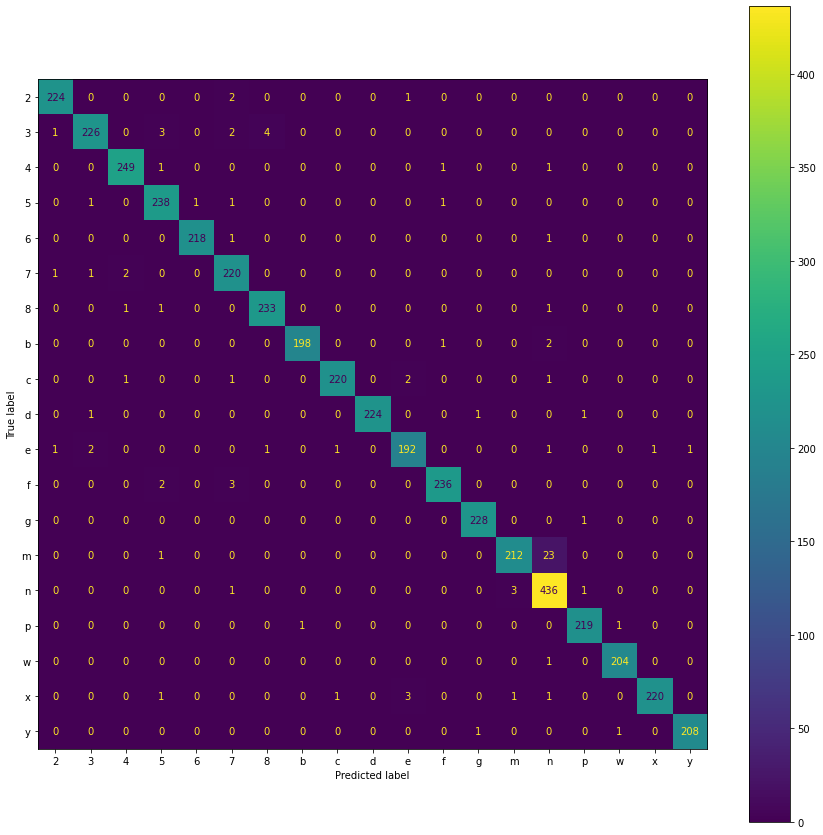

In [ ]:
print(metrics.accuracy_score(y_true, y_pred)) 
print(metrics.balanced_accuracy_score(y_true, y_pred)) 
print(metrics.precision_score(y_true, y_pred,average="macro"))
print(metrics.recall_score(y_true, y_pred,average="macro"))
print(metrics.f1_score(y_true, y_pred,average="macro")) 

conf_mat = metrics.confusion_matrix(y_true, y_pred) 
print(conf_mat.shape)
conf_dis = metrics.ConfusionMatrixDisplay(conf_mat, display_labels=characters)
fig, ax = plt.subplots(figsize=(15, 15))
conf_dis.plot(ax = ax)

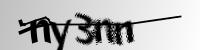

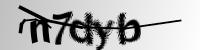

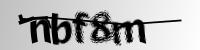

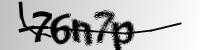

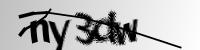

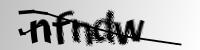

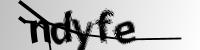

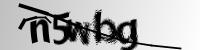

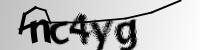

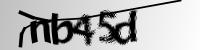

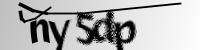

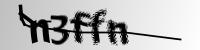

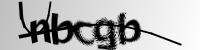

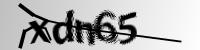

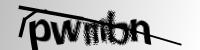

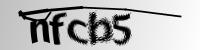

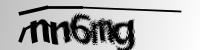

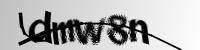

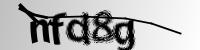

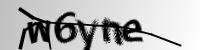

In [ ]:
# p를 b로 misclassification한 경우
for i in range(len(index)):
  cv2_imshow(train_X[index[i]] * 255)